In [27]:
import os
from os import listdir, makedirs, remove
import os.path as osp
from datetime import datetime, timedelta
from numpy.random import Generator, PCG64
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping


# Data Processing

In [28]:
interval = 60

In [29]:
# Loading datasets obtained from pre-processing stage.
tinterval_df = pd.read_csv("/content/drive/My Drive/data_int_{}/tinterval.csv".format(interval))
data_df= pd.read_csv("/content/drive/My Drive/data_int_{}/metro_formated_data.csv".format(interval))

In [30]:
#Joining both dataframes
time_df = data_df.merge(tinterval_df, how= 'left', left_on='time_id', right_on= 'interval_id')
time_df = time_df.drop(columns= ['time_id', 'Unnamed: 0','interval_id','outer_limit'])
time_df = time_df.rename(columns={'inner_limit' : 'date_time'})
time_df = time_df[['date_time', 'station_id', 'docks_demand', 'bikes_demand']]
time_df['date_time'] = pd.to_datetime(time_df['date_time'])

In [31]:
#Removing Virtual Station and Fake Stations from Data
print(time_df.shape)
time_df = time_df[time_df.station_id != 3000]
time_df = time_df[time_df.station_id != 4285]
time_df = time_df[time_df.station_id != 4286]

(4979760, 4)


In [32]:
# Sorting and reindexing columns
time_df=time_df.sort_values(by ='date_time')

In [33]:
#Removing Nan values
df_3005 = time_df[time_df.station_id == 3005]

In [34]:
# Obtain values for station 3005's bike and docks demand separately.
df_3005_bike = df_3005[['date_time', 'bikes_demand']]
df_3005_docks = df_3005[['date_time', 'docks_demand']]
df_3005_bike.set_index('date_time', inplace=True)
df_3005_docks.set_index('date_time', inplace=True)
print(df_3005_bike.head(2))
print(df_3005_docks.head(2))


                     bikes_demand
date_time                        
2019-01-01 00:00:00             0
2019-01-01 01:00:00             0
                     docks_demand
date_time                        
2019-01-01 00:00:00             0
2019-01-01 01:00:00             1


#Training the model for bikes demand 
Splitting data in 80:20 ratio


In [35]:
split = int(len(df_3005_bike)*0.80)
training_set = df_3005_bike.iloc[:split, ].values
test_set = df_3005_bike.iloc[split:, ].values

In [36]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, split):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [37]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

In [38]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 30, batch_size = 32, validation_split= 0.2,
                    callbacks = EarlyStopping(monitor='val_loss', patience = 5))

Epoch 1/30
611/611 [==============================] - 72s 117ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 2/30
611/611 [==============================] - 72s 117ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 3/30
611/611 [==============================] - 72s 117ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 4/30
611/611 [==============================] - 72s 119ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 5/30
611/611 [==============================] - 73s 120ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 6/30
611/611 [==============================] - 73s 119ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 7/30
611/611 [==============================] - 74s 122ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 8/30
611/611 [==============================] - 76s 124ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 9/30
611/611 [==============================] - 74s 121ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 10/30
611/611 [==============================] - 74s 120ms/step - l

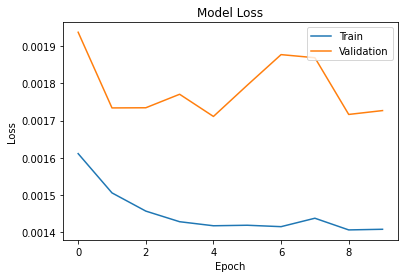

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [40]:
lstm_int60_loss = pd.DataFrame(columns= ['Train_Loss', 'Val_Loss'])
lstm_int60_loss['Train_Loss'] = history.history['loss']
lstm_int60_loss['Val_Loss'] = history.history['val_loss']
lstm_int60_loss.to_csv('lstm_int60_loss.csv')

In [41]:
# 
dataset_train = df_3005_bike.iloc[:split, ]
dataset_test = df_3005_bike.iloc[split:, ]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(dataset_test)+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(6125, 60, 1)


In [42]:
predicted_bike_demand = model.predict(X_test)
predicted_bike_demand = sc.inverse_transform(predicted_bike_demand)

In [43]:
#Evaluation
print('Evaluation')
print( "Mean Squareed Error: ", mean_squared_error(dataset_test.values,predicted_bike_demand))
print("Mean Absolute Error: ", mean_absolute_error(dataset_test.values,predicted_bike_demand))
print( "Root Mean Square Error: ", np.sqrt(mean_squared_error(dataset_test.values,predicted_bike_demand)))

Evaluation
Mean Squareed Error:  2.682745965064132
Mean Absolute Error:  1.1006068964223472
Root Mean Square Error:  1.6379090222183075


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


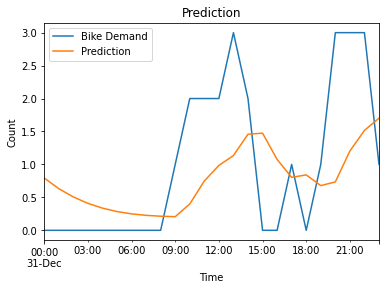

In [44]:
# Visualising the results

eval_df = dataset_test
eval_df['Predictions'] = predicted_bike_demand

eval_df.tail(24).plot()
plt.title('Bikes Demand')
plt.ylabel('Count')
plt.xlabel('Time')
plt.legend(['Bike Demand', 'Prediction'], loc='upper left')
plt.show()

In [ ]:
eval_df.to_csv('lstm_60_results.csv')

Docks Demand

In [45]:
split = int(len(df_3005_docks)*0.80)
training_set_dock = df_3005_docks.iloc[:split, ].values
test_set_dock = df_3005_docks.iloc[split:, ].values

In [46]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set_dock)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, split):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [47]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)               

In [48]:
# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 30, batch_size = 32, 
                    validation_split= 0.2, 
                    callbacks = EarlyStopping(monitor='val_loss', patience = 5))

Epoch 1/30
611/611 [==============================] - 73s 119ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 2/30
611/611 [==============================] - 75s 122ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 3/30
611/611 [==============================] - 72s 118ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 4/30
611/611 [==============================] - 72s 118ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 5/30
611/611 [==============================] - 72s 118ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 6/30
611/611 [==============================] - 72s 119ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 7/30
611/611 [==============================] - 72s 118ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 8/30
611/611 [==============================] - 72s 118ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 9/30
611/611 [==============================] - 73s 119ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 10/30
611/611 [==============================] - 75s 123ms/step - l

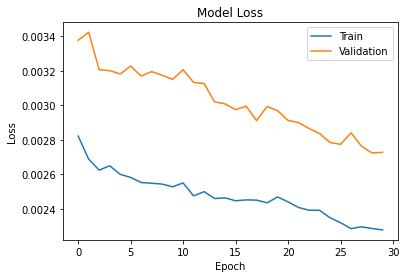

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [50]:
# 
dataset_train_docks = df_3005_docks.iloc[:split, ]
dataset_test_docks = df_3005_docks.iloc[split:, ]
dataset_total = pd.concat((dataset_train_docks, dataset_test_docks), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test_docks)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(dataset_test_docks)+60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(6125, 60, 1)


In [51]:
predicted_docks_demand = model.predict(X_test)
predicted_docks_demand = sc.inverse_transform(predicted_docks_demand)

In [52]:
#Evaluation
print('Evaluation')
print( "Mean Squareed Error: ", mean_squared_error(dataset_test_docks.values,predicted_docks_demand))
print("Mean Absolute Error: ", mean_absolute_error(dataset_test_docks.values,predicted_docks_demand))
print( "Root Mean Square Error: ", np.sqrt(mean_squared_error(dataset_test_docks.values,predicted_docks_demand)))

Evaluation
Mean Squareed Error:  2.4237230066825326
Mean Absolute Error:  1.0971320680306882
Root Mean Square Error:  1.5568310784033483


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


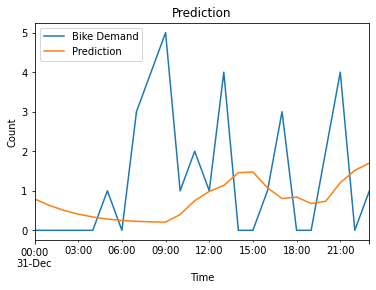

In [53]:
# Visualising the results
eval_df = dataset_test_docks
eval_df['Predictions'] = predicted_bike_demand

eval_df.tail(24).plot()
plt.title('Docks Demand')
plt.ylabel('Count')
plt.xlabel('Time')
plt.legend(['Bike Demand', 'Prediction'], loc='upper left')
plt.show()